In [1]:
import pickle
import numpy as np
import ffsim
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_circuit_layout
import mapomatic as mm
from qiskit import qpy
import os
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_coupling_map
import pandas as pd
import math
from sqd_lattice.util import load_json,load_yaml,load_pickle,save_json,save_pickle
from sqd_lattice.circuits import make_circuit_qiskit
from sqd_lattice.transpiling import _heron_coords_r2,_heron_coords,_eagle_coords,active_qubits,active_gates,color_qubits
from sqd_lattice.transpiling import color_gates,plot_circuit_on_backend,active_qubits

instances:

band-gaps-premium-eu 

band-gaps-premium-us 

band-gaps-eu 

band-gaps-us 


In [2]:
material = 'zirconia'
ne = '25'

folder_path = f"../runs/{material}/{ne}e"

base_config = load_yaml(f"../runs/{material}","base_config.yaml")
hardware_config = load_yaml(f"../runs/{material}","hardware_config.yaml")
data_dict = load_pickle(f"../runs/{material}","data_dict.pkl")
results_pre_process = load_pickle(folder_path,"results_pre_process.pkl")

num_orbitals = data_dict["num_orbitals"]

circ_ffsim = results_pre_process["circ_ffsim"]

circ_qiskit = make_circuit_qiskit(circ_ffsim,num_orbitals,results_pre_process["ne_ab"],results_pre_process["mo_coeff"])

service = QiskitRuntimeService(name="band-gaps-premium-us")
backend = service.backend(hardware_config["processor"],use_fractional_gates=hardware_config["fractional_gates"])

AccountNotFoundError: 'Account with the name band-gaps-premium-us does not exist on disk.'

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
  token="token",
  channel="ibm_cloud",
  instance="instance",
  name="name",
  overwrite=True
)

service = QiskitRuntimeService(name="name")

service.backends()

[<IBMBackend('ibm_pittsburgh')>,
 <IBMBackend('ibm_fez')>,
 <IBMBackend('ibm_torino')>,
 <IBMBackend('ibm_marrakesh')>,
 <IBMBackend('ibm_kingston')>]

In [3]:
spin_a_layout = hardware_config["spin_a_layout"]
spin_b_layout = hardware_config["spin_b_layout"]

initial_layout = spin_a_layout + spin_b_layout

pass_manager = generate_preset_pass_manager(optimization_level=3, 
                                            backend=backend,
                                            # basis_gates=['cz', 'x', 'sx', 'rz'],
                                            initial_layout=initial_layout,
                                            approximation_degree=1,
                                            seed_transpiler=1
)

pass_manager.pre_init = ffsim.qiskit.PRE_INIT
transpiled = pass_manager.run(circ_qiskit)

for inst in transpiled._data:
    if inst.name =='swap':
        print(inst.qubits)

print("Gate counts:")
print(transpiled.count_ops())
print("Depth:")
print(transpiled.depth())
print("2Q Depth:")
print(transpiled.depth(lambda instruction: instruction.operation.num_qubits == 2))

NameError: name 'hardware_config' is not defined

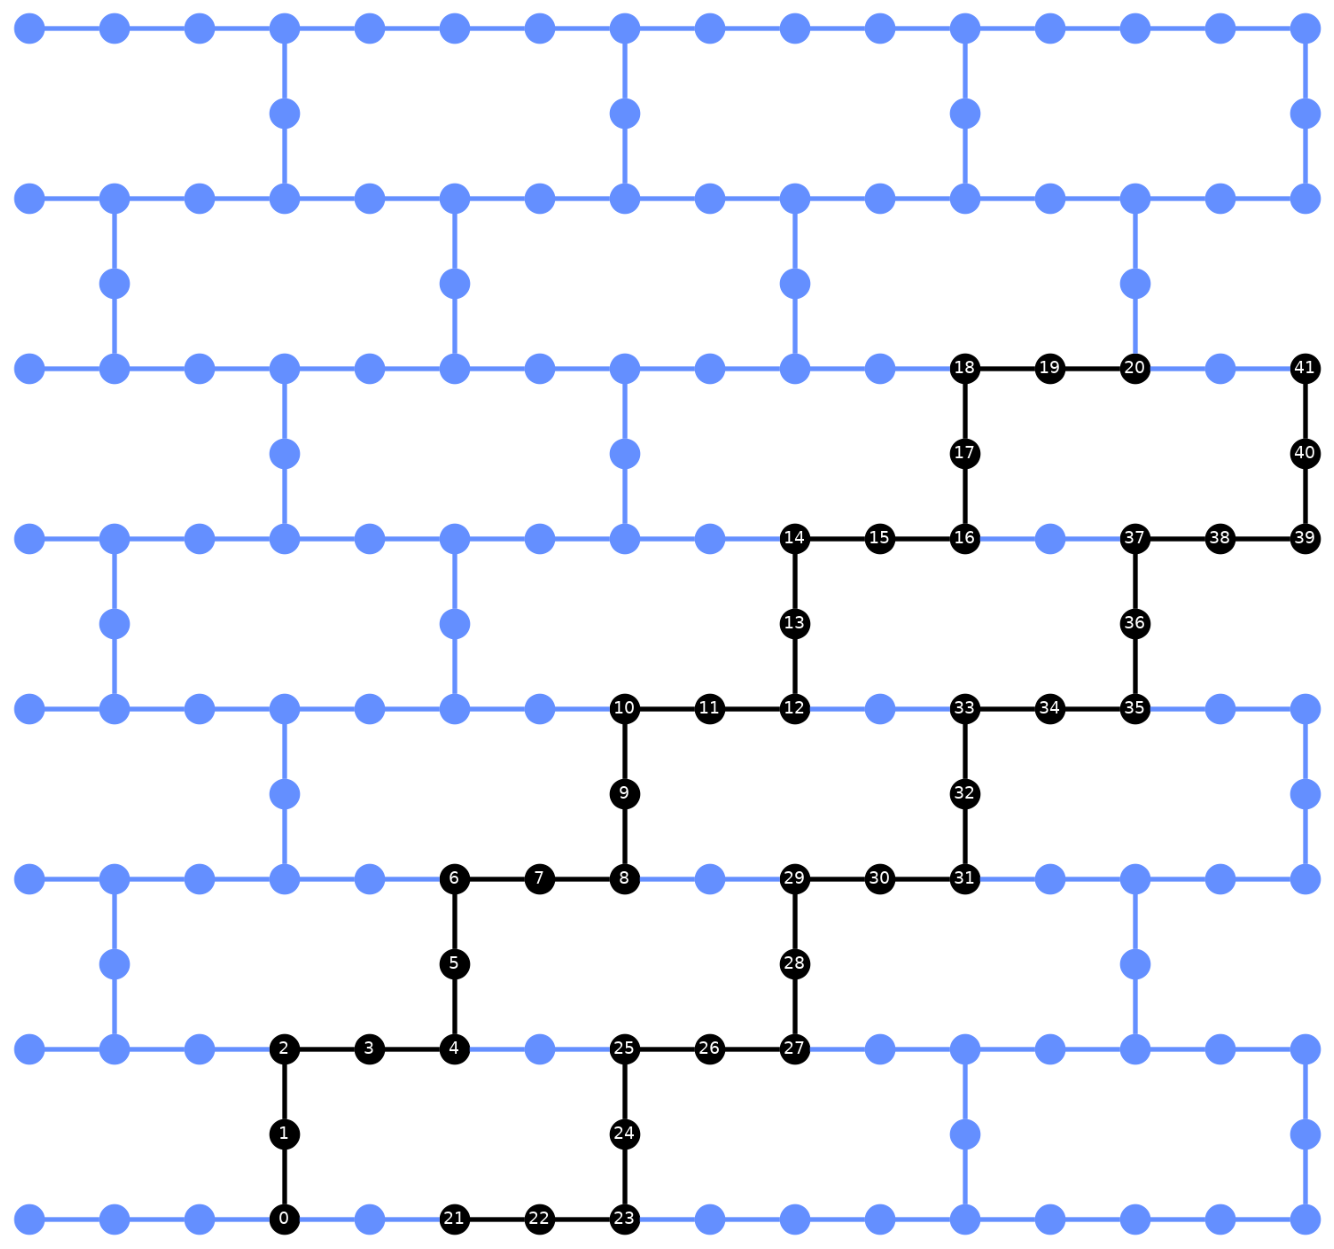

In [7]:
fig = plot_circuit_layout(
    transpiled, backend, view="virtual", qubit_coordinates=_heron_coords_r2()
)
fig.set_size_inches(1 * fig.get_size_inches())
fig

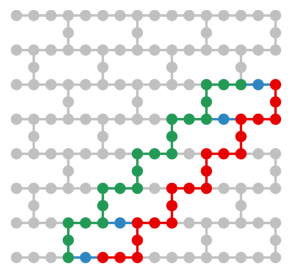

In [8]:
def pairwise(lst):
    return [sorted([lst[i], lst[i+1]]) for i in range(len(lst) - 1)]

f,ax = plt.subplots(figsize=(3.5,3.5))
plot_circuit_on_backend(backend = backend,
                            circuit = transpiled,
                            bad_qubits = spin_b_layout,
                            bad_gates = pairwise(spin_b_layout),
                            initial_layout = initial_layout,
                            show_bad_inactive=False,
                            ax=ax)

plt.savefig(os.path.join("../plots",material,"circuit_layout.pdf"),format='pdf')

In [9]:
# Printing ancilla qubits
act_q = active_qubits(transpiled)
set(act_q)-set(spin_a_layout+spin_b_layout)

{54, 72, 126, 144}

In [10]:
# Deflating circuit, output should be logical qubits + ancillas

small_qc = mm.deflate_circuit(transpiled)
small_qc.num_qubits

46

In [11]:
%%time
# Finding layouts, should have no more than 6 possible layouts

layouts = mm.matching_layouts(small_qc, backend)
print(f'Number of Layouts for H20: {len(layouts)}')

Number of Layouts for H20: 312
CPU times: user 448 ms, sys: 323 μs, total: 448 ms
Wall time: 447 ms


In [12]:
def parse_list(L):
    result = []
    for idx, item in enumerate(L):
        # Skip if item is nan (either float nan or string "nan")
        if isinstance(item, float) and math.isnan(item):
            continue
        if isinstance(item, str) and item.lower() == "nan":
            continue

        # Parse the string into i:f pairs
        for pair in str(item).strip(';').split(';'):
            if pair:
                i_str, f_str = pair.split(':')
                result.append([idx, int(i_str), float(f_str)])
    result.sort(key=lambda x: x[2], reverse=True)

    result = result[::2]
    
    result = {tuple(sorted([item[0],item[1]])):item[2] for item in result}

    return result

# Load the CSV file
df = pd.read_csv(f"../calibrations_{hardware_config['processor']}.csv")

# Extract a specific column
column_name = 'CZ error'  # Change this to the actual column name
column_data = df[column_name]    

bad_connections_dict = parse_list(column_data)
bad_connections_dict

{(119, 133): 0.26157854046926765,
 (40, 41): 0.13975482507737066,
 (112, 113): 0.08163391035628956,
 (85, 86): 0.0699016399401747,
 (86, 87): 0.046960366928749525,
 (151, 152): 0.042898146911373725,
 (153, 154): 0.04223633499660168,
 (82, 83): 0.03773436231165994,
 (139, 155): 0.025891679030066478,
 (64, 65): 0.015316726256569269,
 (25, 26): 0.011626950310327955,
 (3, 4): 0.010459590872277713,
 (26, 27): 0.010252966452855644,
 (4, 5): 0.010070341110889974,
 (76, 81): 0.009263192157081712,
 (129, 130): 0.009164057141417381,
 (81, 82): 0.009001271981258413,
 (122, 123): 0.008166831113748413,
 (126, 127): 0.007514261293039004,
 (123, 136): 0.0070949575346512805,
 (123, 124): 0.007089503910656797,
 (143, 144): 0.006487584887126779,
 (80, 81): 0.00633577941748259,
 (60, 61): 0.006153595927928163,
 (54, 55): 0.006023256334185267,
 (57, 67): 0.0057289732481668465,
 (144, 145): 0.005503753244790605,
 (90, 91): 0.0053082198651144,
 (36, 41): 0.004981931124912714,
 (127, 137): 0.0049286095008099

In [13]:
# Extract a specific column
column_name = 'Readout assignment error'  # Change this to the actual column name
column_data = df[column_name]
bad_qubits = []
bad_qubits_dict = {}
for i in np.argsort(column_data)[::-1]:
    # print(i)
    bad_qubits.append(i)
    bad_qubits_dict[i] = column_data[i]

bad_qubits_dict

{62: np.float64(0.42919921875),
 113: np.float64(0.247314453125),
 40: np.float64(0.2041015625),
 119: np.float64(0.20263671875),
 130: np.float64(0.134521484375),
 79: np.float64(0.103759765625),
 9: np.float64(0.09619140625),
 83: np.float64(0.0927734375),
 51: np.float64(0.08056640625),
 90: np.float64(0.076416015625),
 26: np.float64(0.055419921875),
 23: np.float64(0.05126953125),
 63: np.float64(0.05126953125),
 4: np.float64(0.050048828125),
 58: np.float64(0.04443359375),
 13: np.float64(0.030517578125),
 25: np.float64(0.029296875),
 135: np.float64(0.02783203125),
 82: np.float64(0.026123046875),
 37: np.float64(0.02587890625),
 47: np.float64(0.024169921875),
 69: np.float64(0.022705078125),
 60: np.float64(0.021728515625),
 121: np.float64(0.020751953125),
 56: np.float64(0.01953125),
 127: np.float64(0.01953125),
 150: np.float64(0.019287109375),
 50: np.float64(0.01904296875),
 31: np.float64(0.01904296875),
 145: np.float64(0.018798828125),
 65: np.float64(0.017822265625

Old calibration data

In [14]:
# # Load the CSV file
# df = pd.read_csv(f"../calibrations_{hardware_config['processor']}.csv")

# # Extract a specific column
# column_name = 'CZ error'  # Change this to the actual column name
# column_data = df[column_name]  

# def parse_string_list(string_list):
#     result_dict = {}
#     for s in string_list:
#         pairs = s.split(";")
#         for pair in pairs:
#             key, value = pair.split(":")
#             result_dict[float(value)] = key  # Convert the float string to an actual float
#     return result_dict

# def transform_string(s):
#     return [int(x) for x in s.split('_')]

# parsed_dict = parse_string_list(column_data)

# bad_connections = []
# for k in sorted(parsed_dict.keys())[::-1]:
#     print(f'Connection: {parsed_dict[k]}    Error: {k}')
#     bad_connections.append(transform_string(parsed_dict[k]))


# ## Extract a specific column
# column_name = 'Readout assignment error'  # Change this to the actual column name
# column_data = df[column_name]
# bad_qubits = []
# for i in np.argsort(column_data)[::-1]:
#     # print(i)
#     bad_qubits.append(i)

In [15]:
excludeQ = bad_qubits[:7]
bad_connections = [list(k) for k, v in sorted(bad_connections_dict.items(), key=lambda item: item[1], reverse=True)]
exclude_G = bad_connections[:18]

goodlay = []
temp =[]
for l in layouts:
    if len(set(l)-set(excludeQ)) == len(l):
        temp.append(l)

exlude_list = []
for t in temp:
    cntr = 0
    for g in exclude_G:
        if g[0] in t and g[1] in t:
            cntr +=1
    if cntr == 0:
        goodlay.append(t)
            
print(f'Number of layouts excluding bad Q: {len(temp)}')    
print(f'Number of layouts excluding bad gates too: {len(goodlay)}') 

Number of layouts excluding bad Q: 64
Number of layouts excluding bad gates too: 8


In [16]:
%%time
scores = mm.evaluate_layouts(small_qc, goodlay, backend)
print(f'Fidelity of best Layout H20: {1-scores[0][-1]}')

Fidelity of best Layout H20: 0.002671589023205523
CPU times: user 1.64 s, sys: 3.73 ms, total: 1.65 s
Wall time: 1.65 s


In [17]:
pm_aftermappo     = generate_preset_pass_manager(3,
                                        backend,
                                        initial_layout=scores[0][0], 
                                        # basis_gates=['cz', 'sx','x', 'rz'], 
                                        approximation_degree=1,
                                        seed_transpiler=1
                                        )

best_transpiled = pm_aftermappo.run(mm.deflate_circuit(small_qc))

print(f'Ops Count: {best_transpiled.count_ops()}')

Ops Count: OrderedDict([('sx', 4320), ('rz', 4239), ('cz', 1332), ('x', 100), ('measure', 42), ('barrier', 1)])


In [18]:
print("Gate counts:")
print(transpiled.count_ops())
print("Depth:")
print(transpiled.depth())
print("2Q Depth:")
print(transpiled.depth(lambda instruction: instruction.operation.num_qubits == 2))

Gate counts:
OrderedDict([('sx', 4320), ('rz', 4239), ('cz', 1332), ('x', 100), ('measure', 42), ('barrier', 1)])
Depth:
378
2Q Depth:
88


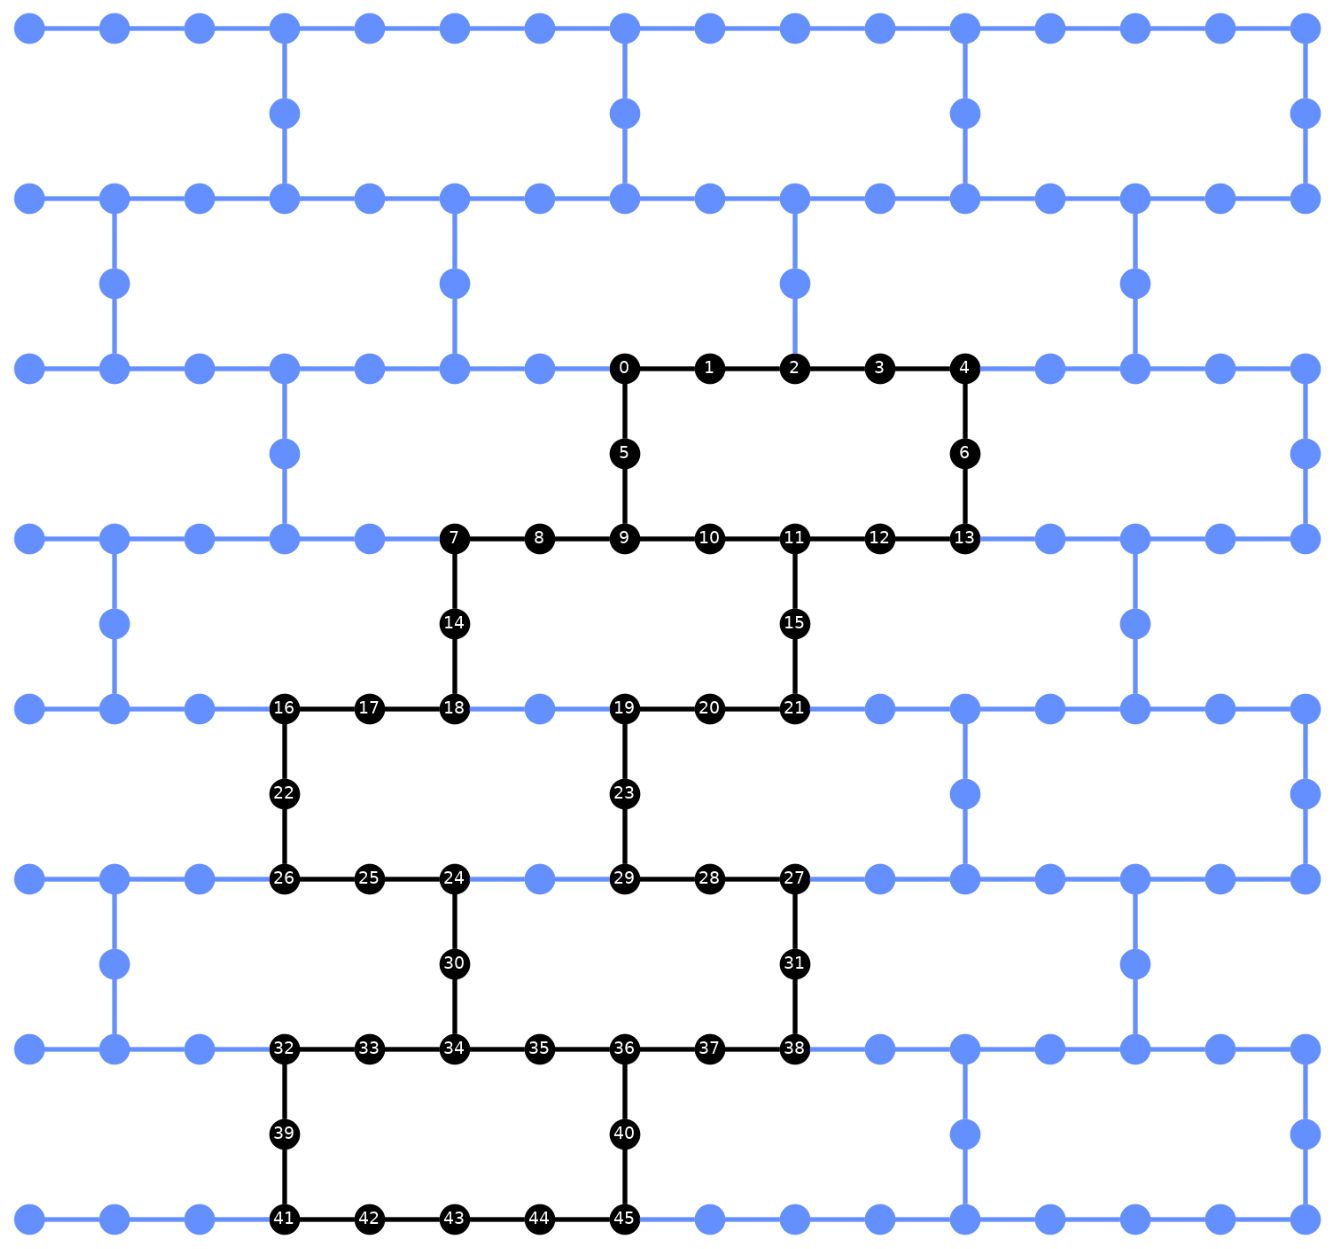

In [19]:
fig = plot_circuit_layout(
    best_transpiled, backend, view="virtual", qubit_coordinates=_heron_coords_r2()
)
fig.set_size_inches(1 * fig.get_size_inches())
fig

In [20]:
from qiskit import qpy

qpy.dump(best_transpiled,open(os.path.join(folder_path,f'transpiled_hardware.qpy'),'wb'))